## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

**Note:** Most of the code in this project was directly gathered from the quizzes on the lessons and also from the Self-Driving Car Project Q&A | Vehicle Tracking (02/10/17). Several improvements were made including but not limited to: implementing a multiple window size sliding-window technique; fixing the bugs on the find_cars helper function when using individual HOG channels; and using a CalibratedClassifierCV to be able to threshold vehicle detections utilizing class probabilities.

---
## Step 1: Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.

#### Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

There are a few functions that are used to extract HOG features, all within the `features.py` file. The two most important are `single_img_features` (lines 48 to 97) which is used to extract HOG features from a single image and `extract_features` which is used to extract HOG features from a list of images (lines 102 to 153.) Both functions work exactly the same way:
- Apply color conversion using `cv2.cvtColor`
- Compute spatial binning features (using the `bin_spatial` function - lines 28 to 32.)
- Compute color histogram features (using the `color_hist` function - lines 36 to 44.)
- Compute single or multi-channel HOG features (using the `get_hog_features` function - lines 8 to 24.)
- Concatenate and return the above features.

I settled on my final choice of HOG parameters (see dark green column to the left of the table below for details) after lots of trial and error. First I read the following whitepapers [1](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) and [2](http://acsweb.ucsd.edu/~yuw176/report/vehicle.pdf) and decided to hold `orient` (9), `pix_per_cell` (8), `cell_per_block` (2) constant. `spatial_feat`, `hist_feat` and `hog_feat` were all left default to `True`. After attending the Q&A session, I decided to keep `color_space` (YCrCb) but I also tried with RGB, HSV and HLS, `hog_channel` (ALL) constant. So the trial and error consisted on testing different values for `spatial_size` and `hist_bins` (and the other parameters not directly controlling HOG but crucial for proper car identification and tracking like `scale` (2.5), `cells_per_step` (1), `threshold` (1), etc.)

#### HOG parameters investigation
![alt text](HOG_parameters.png "")

#### Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

Training of a Linear Support Vector classifier (Linear SVC) is done below at the 4th code cell in the following manner:
- Features (spatial, color histogram and HOG) were extracted from car and notcar images using `extract_features`.
- Features were stacked then normalized using a `StandardScaler`.
- Features were randomized and split into training and test sets.
- The `LinearSVC` was wrapped into a `CalibratedClassifierCV` so we could get class probabilities.
- The CalibratedClassifierCV wsa trained and its accuracy scored (0.9882).

### Make a list of images to read in.

In [28]:
import os
import glob

basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


### Get some sample car and not-car images and apply feature extraction, then visualize the original and feature extracted images.

In [29]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from features import single_img_features, extract_features, apply_threshold
from window import visualize, slide_window, search_windows, draw_boxes, find_cars, draw_labeled_bboxes

# Choose a single sample of random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# YCrCb tends to pickup gradients very well
# In this color space, the influence of illumination difference is reduced
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions - changing this to 32 reduces accuracy
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Extract features from car / not-car images
car_features, car_hog_image = single_img_features(car_image, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

### Car / noncar images and their extracted HOG feature representations

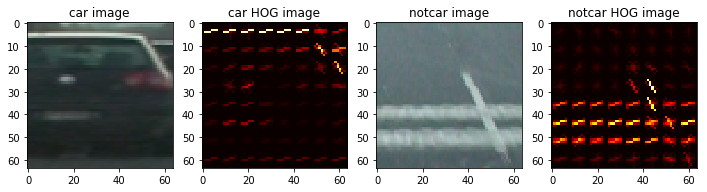

In [30]:
# Visualize the car / not-car images
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))#, dpi=80)
visualize(fig, 1, 4, images, titles)

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier. Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Normalize your features and randomize a selection for training and testing.

In [31]:
# Redefine some feature extraction parameters
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
# n_samples = 1000
# random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

# Extract features from car / not-car images
print('Computing features...')

car_features = extract_features(test_cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time()-t, 2), 'seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64) # StandardScaler expects np.float64
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state) #test_size=0.2 on lesson

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Wrap linear SVC on calibrated classifier so we can get probabilities
clf = CalibratedClassifierCV(svc)
# Check the training time for the SVC
t=time.time()
print('Training svc...')
clf.fit(X_train, y_train)
print(round(time.time()-t, 2), 'seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Computing features...
56.05 seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Training svc...
17.99 seconds to train SVC...
Test Accuracy of SVC =  0.9916


## Step 2: Implement a sliding-window technique and use your trained classifier to search for vehicles in images. Use the sample images from the video to test classifier and extract HOG features using multiple window sizes

#### Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

The sliding window algorithm is composed of the `slide_window` and `search_windows` functions within the `window.py` file (lines 12 to 92.) The actual multi-scale algorithm where these functions are used can be found below.

The [Multi-scale Windows lesson](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/4fc7adb8-c90c-4ac9-befd-0de118d5b4f2) suggested to use 4 different scales which I used as a basis to come up with the following scales (`xy_window`) - Max (**420x420**), 2 x Intermediate (**240x240** and **120x120**) and Min (**60x60**)). I estimated the mid-y coordinate of all squares to be **430** and then visually estimated the left and right x coordinates (`x_start_stop`) that made sense based on the most likely location of cars on the road for each scale. The top and bottom y coordinates (`y_start_stop`) were easily calculated as I assumed there only was one row of each window scale sizes.

#### Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

You can find some test images that demonstrate how the pipeline is working below. By only using 4 scales and assuming a single line of windows per scale we were able to dramatically reducing the number of total windows (i.e. 38) which greatly improved the performance of the classifier.

In [32]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # we trained with .png images (scaled 0 to 1 by mpimp)
    # so we have to scale our test .jpg images (scaled 0 to 255) to the same scale
    img = img.astype(np.float32)/255

    # We use 4 window sizes, X-LARGE: 420x420, LARGE: 240x240, MEDIUM: 120x120 and SMALL: 60x60
    w1 = slide_window(img, x_start_stop=[500, 920], y_start_stop=[400, 460], xy_window=(60, 60), xy_overlap=(0.5, 0.5))
    w2 = slide_window(img, x_start_stop=[380, 1100], y_start_stop=[370, 490], xy_window=(120, 120), xy_overlap=(0.5, 0.5))
    w3 = slide_window(img, x_start_stop=[70, 1270], y_start_stop=[310, 550], xy_window=(240, 240), xy_overlap=(0.5, 0.5))
    w4 = slide_window(img, x_start_stop=[10, 1270], y_start_stop=[220, 640], xy_window=(420, 420), xy_overlap=(0.5, 0.5))
    windows = w1 + w2 + w3 + w4

    hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(round(time.time()-t1, 2), 'seconds to process one image searching', len(windows), 'windows')

0.21 seconds to process one image searching 38 windows
0.17 seconds to process one image searching 38 windows
0.2 seconds to process one image searching 38 windows
0.19 seconds to process one image searching 38 windows
0.17 seconds to process one image searching 38 windows
0.18 seconds to process one image searching 38 windows


### Test images after being processed by the sliding window technique and the trained classifier

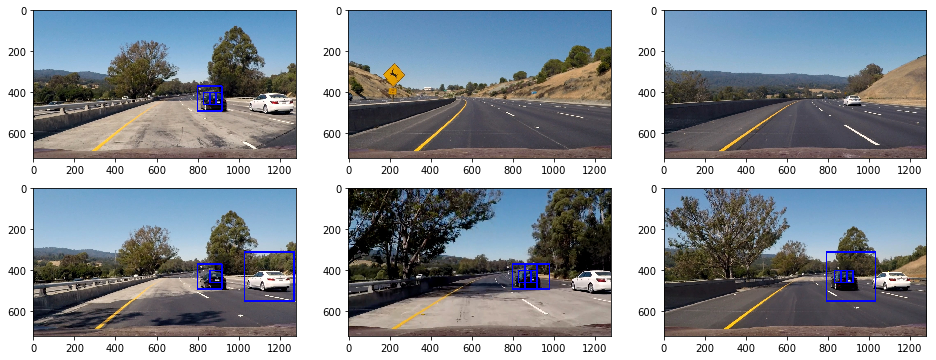

In [33]:
# visualize sliding-window results
fig = plt.figure(figsize=(16,6))
visualize(fig, 2, 3, images, titles)

### Extract HOG features just once for the entire region of interest in each full image / video frame using the `find-cars` helper function. Try to eliminate multiple detections & false positives by using a heatmap and imposing a threshold.

In [34]:
from scipy.ndimage.measurements import label
# We use the label function to find individual contiguous pixels in the heatmap

out_titles = []
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
threshold = 1 # number of detections needs to be more than this to stay in the heatmap
# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    # find cars
    out_img, heat_map = find_cars(img, scale, hog_channel, ystart, ystop, orient, pix_per_cell,
                                  cell_per_block, spatial_size, hist_bins, 
                                  clf, scl=X_scaler, prob_threshold=0.8, cps=1)
    # apply threshold
    heat_map = apply_threshold(heat_map, threshold)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])

### Test images and their corresponding heatmaps

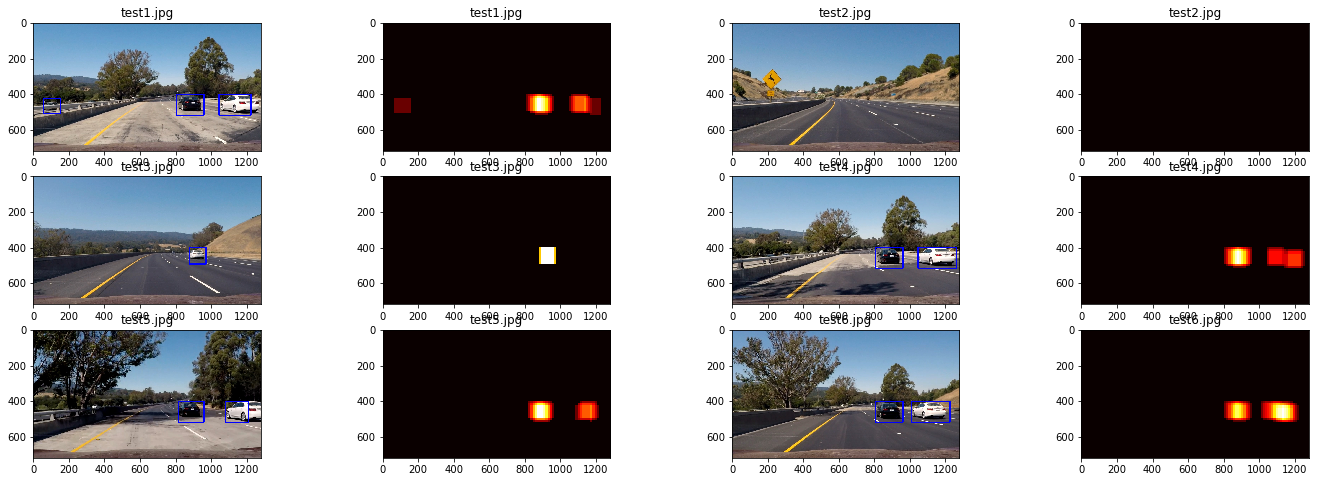

In [35]:
# visualize full image HOG extractiong results
fig = plt.figure(figsize=(24,8))
visualize(fig, 3, 4, out_images, out_titles)

## Step 3: Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles. Estimate a bounding box for vehicles detected.

#### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Link to video [here](https://www.youtube.com/watch?v=hfmE_o3BxYo) and also embedded below.

#### Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

A **heatmap** of detections was generated. To filter false positives **thresholding** was applied both for class probability and the detections heatmap.
- Heatmap creation and class probability thresholding are done within the `find_cars` function inside the `window.py` file (lines 221 to 226.)
 - Everytime a patch was predicted to contain a car, all of the pixels within that patch had their values ('heat') increased.
 - Probability thresholding was done using the `predict_proba` function of the `CalibratedClassifierCV` class which wraps the `LinearSVC` class.
- Heatmap thresholding is done within the `apply_threshold` function inside the `features.py` file (lines 156 to 160.)

In [10]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale, hog_channel, ystart, ystop, orient, pix_per_cell,
                                  cell_per_block, spatial_size, hist_bins, 
                                  clf, scl=X_scaler, prob_threshold=0.8, cps=1)
    heat_map = apply_threshold(heat_map, threshold)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [35:52<00:01,  1.70s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



## Discussion

#### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

- Suprisingly, extracting HOG features just once for the entire region of interest was actually slower than using the multi-scale sliding-window technique. This may be due to my aggresive use of 90% overlap (`cells_per_step` = 1) to achieve acceptable accuracy levels.
- Coming up with a proper set of HOG and other pipeline parameters was very involved and time consuming and involved re-rendering the entire video each time.
- My pipeline would most likely fail whenever there are objects that become mostly occluded for a long time. It can be made more robust by keeping the location history of cars for a few frames and smoothing the position over time.